##### Copyright 2021 The Cirq Developers

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/qcvv/xeb_characterization_pipeline>"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/qcvv/xeb_characterization_pipeline.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/qcvv/xeb_characterization_pipeline.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/qcvv/xeb_characterization_pipeline.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

This notebook is a straightforward outline of how to characterize coherent error with [Cross Entropy Benchmarking (XEB)](./xeb_theory.ipynb). 

In [2]:
try:
    import cirq
except ImportError:
    !pip install --quiet cirq
    import cirq
import numpy as np

     |████████████████████████████████| 593 kB 5.2 MB/s 
     |████████████████████████████████| 48 kB 5.2 MB/s 
     |████████████████████████████████| 1.8 MB 47.2 MB/s 
     |████████████████████████████████| 541 kB 45.8 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 10.1 MB 27.7 MB/s 
     |████████████████████████████████| 65 kB 3.6 MB/s 
     |████████████████████████████████| 145 kB 50.5 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 220 kB 69.8 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 38.1 MB 50.0 MB/s 
     |████████████████████████████████| 229 kB 67.0 MB/s 
     |████████████████████████████████| 44 kB 2.3 MB/s 
     |████████████████████████████████| 243 kB 64.3 MB/s 
     |███████████████████████

## Set up Random Circuits

Create a library of random, two-qubit `circuits` using the `SQRT_ISWAP` gate. These library circuits will be truncated by `cycle_depths` and mixed-and-matched among all the qubit pairs on the device to be characterized.

In [3]:
from cirq.experiments import random_quantum_circuit_generation as rqcg

RANDOM_SEED = np.random.RandomState(53)
circuit_library = rqcg.generate_library_of_2q_circuits(
    n_library_circuits=20, 
    two_qubit_gate=cirq.SQRT_ISWAP,
    random_state=RANDOM_SEED,
)

In [4]:
# Will truncate to these lengths
max_depth = 100
cycle_depths = np.arange(3, max_depth, 20)
cycle_depths

array([ 3, 23, 43, 63, 83])

## Determine the device topology

XEB can be run on all pairs from a given device topology. Below, you can supply a `device_name` if you're authenticated to run on Google QCS. That case will get the device object from the cloud endpoint and turn it into a graph of qubits. Otherwise, mock a device graph by allocating arbitrary `cirq.GridQubit`s into a graph.

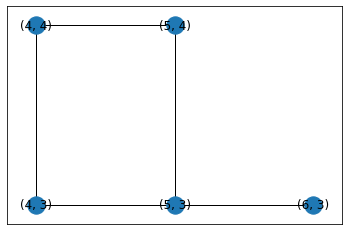

In [5]:
device_name = None  # change me!

import networkx as nx
import itertools

if device_name is not None:
    import cirq_google as cg
    sampler = cg.get_engine_sampler(device_name, gate_set_name='sqrt_iswap')
    device = cg.get_engine_device(device_name)
    qubits = sorted(device.qubits)
else:
    qubits = cirq.GridQubit.rect(3, 2, 4, 3)
    # Delete one qubit from the rectangular arangement to
    # 1) make it irregular 2) simplify simulation.
    qubits = qubits[:-1]
    noise_model = cirq.ConstantQubitNoiseModel(cirq.depolarize(5e-3))
    sampler = cirq.DensityMatrixSimulator(noise=noise_model)

# create a graph from adjacent qubits and draw it
graph = nx.Graph((q1,q2) for (q1,q2) in itertools.combinations(qubits, r=2) if q1.is_adjacent(q2))
pos = {q: (q.row, q.col) for q in qubits}
nx.draw_networkx(graph, pos=pos)

## Set up qubit pair combinations

XEB can be performed in a parallel or isolated manner. In the parallel case, multiple qubits are "active" to be tested simultaneously in the same circuit, where the isolated case has only one active pair running at any time. The following cell creates the `combs_by_layer` data structure, which defines which qubit pairs are active in parallel, and which two-qubit circuits (from `circuit_library`) will be applied to each of the active pairs.

The outer list  of `combs_by_layer` corresponds to the different layers. Each inner layer defines the `combinations` matrix, which indexes the circuit library circuits to use, and the `pairs` list, which notes which qubit pairs are active.

In [6]:
parallel = True

if parallel:
  # automatically selects multiple active pairs per layer
  combs_by_layer = rqcg.get_random_combinations_for_device(
      n_library_circuits=len(circuit_library),
      n_combinations=10,
      device_graph=graph,
      random_state=RANDOM_SEED,
  )
else:
  # only one active pair per layer
  layer_pairs = [[pair] for pair in graph.edges]
  combs_by_layer = rqcg.get_random_combinations_for_pairs(
      n_library_circuits=len(circuit_library), 
      n_combinations=10,
      all_pairs=layer_pairs,
      random_state=RANDOM_SEED,
  )
print(len(combs_by_layer))
combs_by_layer[0]

4


CircuitLibraryCombination(layer=cirq.experiments.GridInteractionLayer(col_offset=0, vertical=True, stagger=True), combinations=array([[ 4, 15],
       [13, 18],
       [10, 12],
       [ 1,  4],
       [14, 17],
       [ 0,  0],
       [19, 14],
       [ 7,  3],
       [ 6, 16],
       [ 6, 19]]), pairs=[(cirq.GridQubit(4, 4), cirq.GridQubit(5, 4)), (cirq.GridQubit(5, 3), cirq.GridQubit(6, 3))])

### Visualize
Here, draw the layers' active pairs to see which qubits will be tested in which layers.

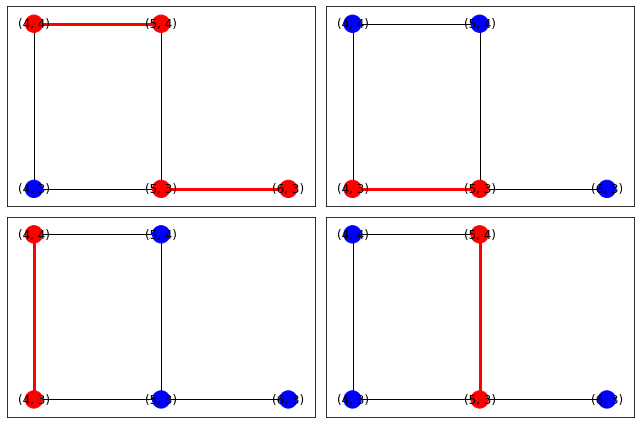

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

ncols = int(len(combs_by_layer)**(1/2))
nrows = ncols+1 if ncols**2 < len(combs_by_layer) else ncols
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(9,6))
for comb_layer, ax in zip(combs_by_layer, axes.reshape(-1)):
    active_qubits = np.array(comb_layer.pairs).reshape(-1)
    # highlight the active qubits in red
    colors = ['red' if q in active_qubits else 'blue' for q in graph.nodes]
    nx.draw_networkx(graph, pos=pos, node_color=colors, ax=ax)
    # highlight the active pair edges in red 
    nx.draw_networkx_edges(graph, pos=pos, edgelist=comb_layer.pairs, width=3, edge_color='red', ax=ax)
    
plt.tight_layout()

## Sample Data

The sampling function `sample_2q_xeb_circuits` zips the circuits of `circuit_library` together according to `combs_by_layer`, before sampling them and computing the sampled probabilities of getting the correct bit string `sampled_probs`. 

For layers with multiple active qubit pairs, it will combine the two-qubit circuits from `circuit_library` by placing different circuits on different active pairs. This creates larger, many-pair circuits, which operate on all the active pairs of a layer in parallel, without ever connecting the distinct pairs' circuits to each other. An inspection of one of the sampled `DataFrame`s reveals the available types of data, including the sampled probabilities `sampled_probs`.


In [8]:
from cirq.experiments.xeb_sampling import sample_2q_xeb_circuits
sampled_df = sample_2q_xeb_circuits(
    sampler=sampler,
    circuits=circuit_library,
    cycle_depths=cycle_depths,
    combinations_by_layer=combs_by_layer,
    shuffle=np.random.RandomState(52),
    repetitions=10_000,
)
sampled_df.head()

100%|██████████| 207/207 [01:53<00:00,  1.83it/s]


,,sampled_probs,timestamp,layer_i,pair_i,combination_i,pair
circuit_i,cycle_depth,,,,,,
4,23,"[0.5244, 0.1108, 0.1542, 0.2106]",1.649555e+09,1,0,6,"((4, 3), (5, 3))"
7,63,"[0.2342, 0.267, 0.2334, 0.2654]",1.649555e+09,2,0,5,"((4, 3), (4, 4))"
1,43,"[0.191, 0.2634, 0.2811, 0.2645]",1.649555e+09,1,0,1,"((4, 3), (5, 3))"
7,23,"[0.116, 0.5457, 0.2283, 0.11]",1.649555e+09,0,0,7,"((4, 4), (5, 4))"
3,23,"[0.3159, 0.1329, 0.2178, 0.3334]",1.649555e+09,0,1,7,"((5, 3), (6, 3))"


## Benchmark Fidelities

The `benchmark_2q_xeb_fidelities` function takes each sampled `DataFrame` and computes the overall fidelity across all of the randomized circuits for each qubit pair and each of the previously defined `cycle_depth`s.

In [9]:
from cirq.experiments.xeb_fitting import benchmark_2q_xeb_fidelities
fids = benchmark_2q_xeb_fidelities(
    sampled_df=sampled_df,
    circuits=circuit_library,
    cycle_depths=cycle_depths,
)
fids.head()

,layer_i,pair_i,cycle_depth,fidelity,pair
0,0,0,3,0.923784,"((4, 4), (5, 4))"
1,0,0,23,0.609420,"((4, 4), (5, 4))"
2,0,0,43,0.397871,"((4, 4), (5, 4))"
3,0,0,63,0.261075,"((4, 4), (5, 4))"
4,0,0,83,0.167190,"((4, 4), (5, 4))"


## Estimate By-Layer Fidelities

Next, use `fit_exponential_decays` on each of the fidelity datasets of `circuit_fidelities`, to estimate a per-layer fidelity, which estimates the fidelity error of the two-qubit entangling gate operation on each individual qubit pair. 

In [10]:
from cirq.experiments.xeb_fitting import fit_exponential_decays, exponential_decay
fidelities = fit_exponential_decays(fids)
fidelities.head()

a  layer_fid         cycle_depths  \
layer_i pair_i pair                                                         
0       0      ((4, 4), (5, 4))  0.985863   0.979099  [3, 23, 43, 63, 83]   
        1      ((5, 3), (6, 3))  0.983222   0.978931  [3, 23, 43, 63, 83]   
1       0      ((4, 3), (5, 3))  0.997131   0.978314  [3, 23, 43, 63, 83]   
2       0      ((4, 3), (4, 4))  0.988668   0.978966  [3, 23, 43, 63, 83]   
3       0      ((5, 3), (5, 4))  0.982421   0.979230  [3, 23, 43, 63, 83]   

                                                                        fidelities  \
layer_i pair_i pair                                                                  
0       0      ((4, 4), (5, 4))  [0.9237841043826969, 0.609419685380498, 0.3978...   
        1      ((5, 3), (6, 3))  [0.923059933482562, 0.599137318358399, 0.39757...   
1       0      ((4, 3), (5, 3))  [0.9320436161769315, 0.6055788537158963, 0.387...   
2       0      ((4, 3), (4, 4))  [0.928302050887004, 0.6051568513305658, 0.3973...   
3       0      ((5, 3), (5, 4))  [0.9234175841861382, 0.6024683665375963, 0.399...   

                                    a_std  layer_fid_std  
layer_i pair_i pair                                       
0       0      ((4, 4), (5, 4))  0.003026       0.000118  
        1      ((5, 3), (6, 3))  0.003956       0.000155  
1       0      ((4, 3), (5, 3))  0.004200       0.000166  
2       0      ((4, 3), (4, 4))  0.004956       0.000193  
3       0      ((5, 3), (5, 4))  0.007927       0.000308

# Visualizations

Plot the fidelity decrease per layer by qubit in a heatmap to compare the different qubits.

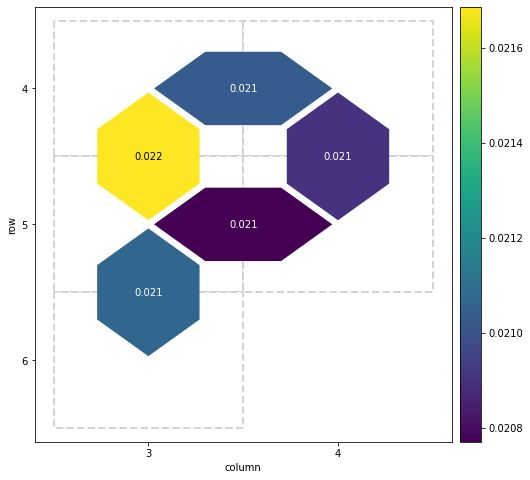

In [11]:
heatmap_data = {}

for (_, _, pair), fidelity in fidelities.layer_fid.items():
    heatmap_data[pair] = 1.0 - fidelity

cirq.TwoQubitInteractionHeatmap(heatmap_data).plot();

Plot the fidelities by cycle depth with their fit exponential decay curves. 

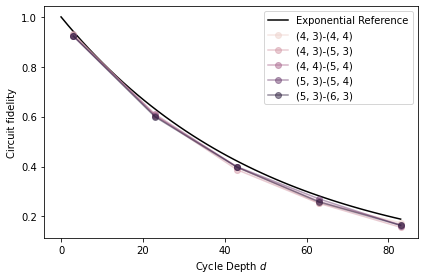

In [12]:
import seaborn as sns

# Give each pair its own color
colors = sns.cubehelix_palette(n_colors=graph.number_of_edges())
colors = dict(zip(graph.edges, colors))

# Exponential reference
xx = np.linspace(0, fids['cycle_depth'].max())
plt.plot(xx, (1-5e-3)**(4*xx), label=r'Exponential Reference', color='black')

# Plot each pair
def _p(fids):
    q0, q1 = fids.name
    plt.plot(fids['cycle_depth'], fids['fidelity'], 
             'o-', label=f'{q0}-{q1}', color=colors[fids.name], alpha=0.5)

fids.groupby('pair').apply(_p)

plt.ylabel('Circuit fidelity')
plt.xlabel('Cycle Depth $d$')
plt.legend(loc='best')
plt.tight_layout()

## Optimize `PhasedFSimGate` parameters

In a real experiment, there is likely unknown coherent error that you would like to characterize. Therefore, make the five angles in `PhasedFSimGate` free parameters in `SqrtISwapXEBOptions`, and use a classical optimizer (`characterize_phased_fsim_parameters_with_xeb_py_pair`) to find out which set of parameters best describes the data collected from the noisy simulator (or device, if this was a real experiment).

In [13]:
import multiprocessing
pool = multiprocessing.get_context('spawn').Pool()

In [14]:
from cirq.experiments.xeb_fitting import (
    parameterize_circuit, 
    characterize_phased_fsim_parameters_with_xeb_by_pair, 
    SqrtISwapXEBOptions,
)

# Set which angles to characterize (all)
options = SqrtISwapXEBOptions(
    characterize_theta = True,
    characterize_zeta = True,
    characterize_chi = True,
    characterize_gamma = True,
    characterize_phi = True
)
# Parameterize the sqrt(iswap)s in the circuit library
pcircuits = [parameterize_circuit(circuit, options) for circuit in circuit_library]

# Run the characterization loop
characterization_result = characterize_phased_fsim_parameters_with_xeb_by_pair(
    sampled_df,
    pcircuits,
    cycle_depths,
    options,
    pool=pool,
    # ease tolerance so it converges faster:
    fatol=1e-2, 
    xatol=1e-2
)

The fitting procedure finds likely parameter values...

In [15]:
characterization_result.final_params

{(cirq.GridQubit(4, 3), cirq.GridQubit(4, 4)): {'chi': 0.02037529198131001,
  'gamma': -0.005770151845868237,
  'phi': -0.0005198600718290568,
  'theta': -0.7851928803578327,
  'zeta': -0.022705831828178112},
 (cirq.GridQubit(4, 3), cirq.GridQubit(5, 3)): {'chi': 0.02373740569445147,
  'gamma': 0.031815630025955416,
  'phi': -0.06668935490334356,
  'theta': -0.7439793396964274,
  'zeta': 0.003769004319030076},
 (cirq.GridQubit(4, 4), cirq.GridQubit(5, 4)): {'chi': 0.03331532047557838,
  'gamma': -0.03806904762344121,
  'phi': 0.041009703698890065,
  'theta': -0.8074109686251106,
  'zeta': 0.020516841481887062},
 (cirq.GridQubit(5, 3), cirq.GridQubit(5, 4)): {'chi': 0.04786113710409455,
  'gamma': -0.0432516537388628,
  'phi': 0.010157780595274633,
  'theta': -0.797927143221915,
  'zeta': -0.010974313481947353},
 (cirq.GridQubit(5, 3), cirq.GridQubit(6, 3)): {'chi': 0.04982173416818004,
  'gamma': -0.016447959339346067,
  'phi': 0.03516921314704577,
  'theta': -0.7519481419032447,
  'ze

and refit fidelities. 

In [16]:
characterization_result.fidelities_df.head()

,layer_i,pair_i,cycle_depth,fidelity,pair
0,1,0,3,0.930326,"((4, 3), (5, 3))"
1,1,0,23,0.646001,"((4, 3), (5, 3))"
2,1,0,43,0.383954,"((4, 3), (5, 3))"
3,1,0,63,0.266585,"((4, 3), (5, 3))"
4,1,0,83,0.169191,"((4, 3), (5, 3))"


The `before_and_after_characterization` function collects the before fidelities, `circuit_fidelities`, and the after fidelities, `characterization_results` into the same data frame, by row, suffixing the data by source with `_0` and `_c` respectively. 

In [17]:
from cirq.experiments.xeb_fitting import before_and_after_characterization
before_after_df = before_and_after_characterization(fids, characterization_result)
before_after_df.head()

,layer_i,pair_i,a_0,layer_fid_0,cycle_depths_0,fidelities_0,a_std_0,layer_fid_std_0,a_c,layer_fid_c,cycle_depths_c,fidelities_c,a_std_c,layer_fid_std_c,characterized_angles,theta,zeta,chi,gamma,phi
pair,,,,,,,,,,,,,,,,,,,,
"((4, 4), (5, 4))",0,0,0.985863,0.979099,"[3, 23, 43, 63, 83]","[0.9237841043826969, 0.609419685380498, 0.3978...",0.003026,0.000118,1.000000,0.979272,"[3, 23, 43, 63, 83]","[0.941899703649229, 0.6243454356060385, 0.3768...",0.024735,0.000942,"{'theta': -0.8074109686251106, 'zeta': 0.02051...",-0.807411,0.020517,0.033315,-0.038069,0.041010
"((5, 3), (6, 3))",0,1,0.983222,0.978931,"[3, 23, 43, 63, 83]","[0.923059933482562, 0.599137318358399, 0.39757...",0.003956,0.000155,0.998778,0.978839,"[3, 23, 43, 63, 83]","[0.9367465054668207, 0.6147352687543447, 0.388...",0.007970,0.000309,"{'theta': -0.7519481419032447, 'zeta': 0.01721...",-0.751948,0.017220,0.049822,-0.016448,0.035169
"((4, 3), (5, 3))",1,0,0.997131,0.978314,"[3, 23, 43, 63, 83]","[0.9320436161769315, 0.6055788537158963, 0.387...",0.004200,0.000166,1.000000,0.979156,"[3, 23, 43, 63, 83]","[0.9303264981622089, 0.6460007684427781, 0.383...",0.023063,0.000882,"{'theta': -0.7439793396964274, 'zeta': 0.00376...",-0.743979,0.003769,0.023737,0.031816,-0.066689
"((4, 3), (4, 4))",2,0,0.988668,0.978966,"[3, 23, 43, 63, 83]","[0.928302050887004, 0.6051568513305658, 0.3973...",0.004956,0.000193,0.976263,0.979704,"[3, 23, 43, 63, 83]","[0.9236833703668422, 0.5938020626009699, 0.411...",0.011349,0.000436,"{'theta': -0.7851928803578327, 'zeta': -0.0227...",-0.785193,-0.022706,0.020375,-0.005770,-0.000520
"((5, 3), (5, 4))",3,0,0.982421,0.979230,"[3, 23, 43, 63, 83]","[0.9234175841861382, 0.6024683665375963, 0.399...",0.007927,0.000308,0.973150,0.981082,"[3, 23, 43, 63, 83]","[0.9196481398762525, 0.6144134126202415, 0.456...",0.020837,0.000765,"{'theta': -0.797927143221915, 'zeta': -0.01097...",-0.797927,-0.010974,0.047861,-0.043252,0.010158


Plot the original fidelities with the refit ones found by the parameter fitting. 

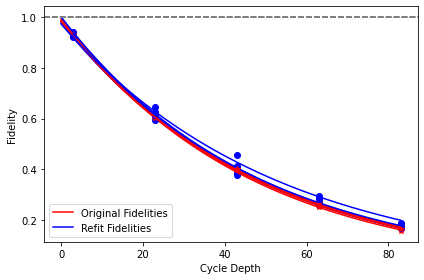

In [18]:
for i, row in before_after_df.iterrows():
    plt.axhline(1, color='grey', ls='--')
    plt.plot(row['cycle_depths_0'], row['fidelities_0'], '*', color='red')
    plt.plot(row['cycle_depths_c'], row['fidelities_c'], 'o', color='blue')

    xx = np.linspace(0, np.max(row['cycle_depths_0']))
    plt.plot(xx, exponential_decay(xx, a=row['a_0'], layer_fid=row['layer_fid_0']), color='red', label='Original Fidelities')
    plt.plot(xx, exponential_decay(xx, a=row['a_c'], layer_fid=row['layer_fid_c']), color='blue', label='Refit Fidelities')
    
    plt.xlabel('Cycle Depth')
    plt.ylabel('Fidelity')

# make the legend labels unique
handles, labels = plt.gca().get_legend_handles_labels()
legend_items = dict(zip(labels, handles))
plt.legend(legend_items.values(), legend_items.keys(), loc='best')
plt.tight_layout()
plt.show()